# Make Neut Curves and Analyze Mouse Neuts

In [22]:
import math

import pandas as pd
import numpy as np
import seaborn as sns

import neutcurve

from plotnine import *

import csv
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.font_manager import FontProperties

import scipy.stats

In [23]:
CBP = neutcurve.colorschemes.CBPALETTE
CBM = neutcurve.colorschemes.CBMARKERS
theme_set(theme_seaborn(style='white', context='talk', font_scale=1))

In [24]:
fidf_rnd1 = pd.read_csv('./fract_infect/201015_fractinfect.csv').drop(['Unnamed: 0'], axis=1)
fidf_rnd2 = pd.read_csv('./fract_infect/201016_fractinfect_rnd2.csv').drop(['Unnamed: 0'], axis=1)

In [4]:
display(fidf_rnd1.head())
display(fidf_rnd2.head())

,serum,virus,replicate,concentration,fraction infectivity
0,0840-1,S-d21-D614G,1,0.050000,0.988406
1,0840-1,S-d21-D614G,1,0.016667,0.999059
2,0840-1,S-d21-D614G,1,0.005556,1.013738
3,0840-1,S-d21-D614G,1,0.001852,0.909787
4,0840-1,S-d21-D614G,1,0.000617,0.900076


,serum,virus,replicate,concentration,fraction infectivity
0,0805-1,S-d21-D614G,1,0.050000,0.625716
1,0805-1,S-d21-D614G,1,0.016667,0.710727
2,0805-1,S-d21-D614G,1,0.005556,0.761430
3,0805-1,S-d21-D614G,1,0.001852,1.159994
4,0805-1,S-d21-D614G,1,0.000617,0.713713


In [5]:
smpls_rnd1 = pd.read_csv('./sample_maps/rnd1_sample_map.csv').rename(columns={'Sample': 'serum'})
smpls_rnd2 = pd.read_csv('./sample_maps/rnd2_sample_map.csv').rename(columns={'Sample': 'serum'})

In [6]:
display(smpls_rnd1.head())
display(smpls_rnd2.head())

,DateSetUp,serum,Plate,SampleNum,Virus,PlateLayout,StartDil,DilFactor
0,201013,0793-1,Plate1,1,S-d21-D614G,layout1.csv,0.05,3
1,201013,0846-1,Plate1,2,S-d21-D614G,layout1.csv,0.05,3
2,201013,0807-1,Plate1,3,S-d21-D614G,layout1.csv,0.05,3
3,201013,0813-1,Plate1,4,S-d21-D614G,layout1.csv,0.05,3
4,201013,0863-1,Plate2,1,S-d21-D614G,layout1.csv,0.05,3


,DateSetUp,serum,Plate,SampleNum,Virus,PlateLayout,StartDil,DilFactor
0,201014,0805-1,Plate1,1,S-d21-D614G,layout1.csv,0.05,3
1,201014,0854-1,Plate1,2,S-d21-D614G,layout1.csv,0.05,3
2,201014,0858-1,Plate1,3,S-d21-D614G,layout1.csv,0.05,3
3,201014,0817-1,Plate1,4,S-d21-D614G,layout1.csv,0.05,3
4,201014,0834-1,Plate2,1,S-d21-D614G,layout1.csv,0.05,3


#### Add plate number to fraction infectivity df

In [25]:
df_rnd1 = fidf_rnd1.merge(smpls_rnd1, how='outer', on='serum').drop(['Virus', 'PlateLayout', 'StartDil', 'DilFactor'], axis=1)
display(df_rnd1.head())

,serum,virus,replicate,concentration,fraction infectivity,DateSetUp,Plate,SampleNum
0,0840-1,S-d21-D614G,1,0.050000,0.988406,201013,Plate7,1
1,0840-1,S-d21-D614G,1,0.016667,0.999059,201013,Plate7,1
2,0840-1,S-d21-D614G,1,0.005556,1.013738,201013,Plate7,1
3,0840-1,S-d21-D614G,1,0.001852,0.909787,201013,Plate7,1
4,0840-1,S-d21-D614G,1,0.000617,0.900076,201013,Plate7,1


In [31]:
df_rnd2 = fidf_rnd2.merge(smpls_rnd2, how='outer', on='serum').drop(['Virus', 'PlateLayout', 'StartDil', 'DilFactor'], axis=1)
display(df_rnd2.head())

,serum,virus,replicate,concentration,fraction infectivity,DateSetUp,Plate,SampleNum
0,0805-1,S-d21-D614G,1,0.050000,0.625716,201014,Plate1,1
1,0805-1,S-d21-D614G,1,0.016667,0.710727,201014,Plate1,1
2,0805-1,S-d21-D614G,1,0.005556,0.761430,201014,Plate1,1
3,0805-1,S-d21-D614G,1,0.001852,1.159994,201014,Plate1,1
4,0805-1,S-d21-D614G,1,0.000617,0.713713,201014,Plate1,1


### Fix Plate 4 Issue for Rnd1

I forgot to discard the last 30 uL from the serum dilutions in row H of plate 4, so I need to drop the final dilution for all plate 

In [33]:
df_rnd1.drop(df_rnd1[(df_rnd1['Plate']=='Plate4')&(df_rnd1['concentration']==(0.05/(3**6)))].index, axis=0, inplace=True)
df_rnd1 = df_rnd1.sort_values(['Plate', 'SampleNum', 'replicate'])
display(df_rnd1)

,serum,virus,replicate,concentration,fraction infectivity,DateSetUp,Plate,SampleNum
336,0793-1,S-d21-D614G,1,0.050000,0.245596,201013,Plate1,1
337,0793-1,S-d21-D614G,1,0.016667,0.396659,201013,Plate1,1
338,0793-1,S-d21-D614G,1,0.005556,0.479400,201013,Plate1,1
339,0793-1,S-d21-D614G,1,0.001852,0.822955,201013,Plate1,1
340,0793-1,S-d21-D614G,1,0.000617,1.009480,201013,Plate1,1
...,...,...,...,...,...,...,...,...
51,20/130 Ref,S-d21-D614G,2,0.002778,0.067901,201013,Plate7,5
52,20/130 Ref,S-d21-D614G,2,0.000926,0.184104,201013,Plate7,5
53,20/130 Ref,S-d21-D614G,2,0.000309,0.379211,201013,Plate7,5
54,20/130 Ref,S-d21-D614G,2,0.000103,0.605273,201013,Plate7,5


## Calculate Fits using Neut Curve

In [34]:
fits_rnd1 = neutcurve.CurveFits(df_rnd1, fixtop=True)
fit_params_rnd1 = fits_rnd1.fitParams(ics=[50, 90])
fit_params_rnd1['nt50'] = 1/fit_params_rnd1['ic50']
fit_params_rnd1['nt90'] = 1/fit_params_rnd1['ic90']

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/neutcurve/hillcurve.py:689: RuntimeWarning: invalid value encountered in power


In [35]:
fits_rnd2 = neutcurve.CurveFits(df_rnd2, fixtop=True)
fits_rnd2_nosp = neutcurve.CurveFits(df_rnd2[df_rnd2['serum'] != '2017-2018 serum pool'], fixtop=True)

In [36]:
# sp_curve = fits_rnd2.getCurve(serum='2017-2018 serum pool', virus='S-d21-D614G', replicate='1')
display(df_rnd2[df_rnd2['serum'] == '2017-2018 serum pool'])


,serum,virus,replicate,concentration,fraction infectivity,DateSetUp,Plate,SampleNum
322,2017-2018 serum pool,S-d21-D614G,1,0.050000,0.860817,201014,Plate6,4
323,2017-2018 serum pool,S-d21-D614G,1,0.016667,0.674258,201014,Plate6,4
324,2017-2018 serum pool,S-d21-D614G,1,0.005556,0.980501,201014,Plate6,4
325,2017-2018 serum pool,S-d21-D614G,1,0.001852,0.887813,201014,Plate6,4
326,2017-2018 serum pool,S-d21-D614G,1,0.000617,0.873441,201014,Plate6,4
327,2017-2018 serum pool,S-d21-D614G,1,0.000206,0.786647,201014,Plate6,4
328,2017-2018 serum pool,S-d21-D614G,1,0.000069,0.830204,201014,Plate6,4


In [37]:
fit_params_rnd2 = fits_rnd2_nosp.fitParams(ics=[50, 90])
fit_params_rnd2['nt50'] = 1/fit_params_rnd2['ic50']
fit_params_rnd2['nt90'] = 1/fit_params_rnd2['ic90']

In [42]:
display(fit_params_rnd1.head())
display(fit_params_rnd2.head())

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90
0,0793-1,S-d21-D614G,average,2,0.010629,interpolated,0.0106,0.050000,lower,>0.05,0.010629,0.831619,True,0,94.080392,20.000000
1,0846-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,4.132835,0.265601,True,0,20.000000,20.000000
2,0807-1,S-d21-D614G,average,2,0.020702,interpolated,0.0207,0.050000,lower,>0.05,0.020702,0.903648,True,0,48.303432,20.000000
3,0813-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,21279.859733,0.126899,True,0,20.000000,20.000000
4,0863-1,S-d21-D614G,average,2,0.000207,interpolated,0.000207,0.000825,interpolated,0.000825,0.000207,1.588156,True,0,4834.077623,1211.892515


,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90
0,0805-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,317328.751658,0.079256,True,0,20.000000,20.000000
1,0854-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,3.622431,3.996576,True,0,20.000000,20.000000
2,0858-1,S-d21-D614G,average,2,0.002211,interpolated,0.00221,0.050000,lower,>0.05,0.002211,0.528155,True,0,452.261297,20.000000
3,0817-1,S-d21-D614G,average,2,0.000075,interpolated,7.54e-05,0.000418,interpolated,0.000418,0.000075,1.283698,True,0,13258.708776,2394.126118
4,0834-1,S-d21-D614G,average,2,0.000096,interpolated,9.6e-05,0.000757,interpolated,0.000757,0.000096,1.063690,True,0,10419.562318,1320.514686


In [43]:
df_fits_rnd1 = pd.merge(fit_params_rnd1, smpls_rnd1, how='outer', on='serum')
df_fits_rnd1.drop(['PlateLayout', 'Virus', 'DilFactor', 'StartDil'], axis=1, inplace=True)
display(df_fits_rnd1.head())

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum
0,0793-1,S-d21-D614G,average,2,0.010629,interpolated,0.0106,0.050000,lower,>0.05,0.010629,0.831619,True,0,94.080392,20.000000,201013,Plate1,1
1,0846-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,4.132835,0.265601,True,0,20.000000,20.000000,201013,Plate1,2
2,0807-1,S-d21-D614G,average,2,0.020702,interpolated,0.0207,0.050000,lower,>0.05,0.020702,0.903648,True,0,48.303432,20.000000,201013,Plate1,3
3,0813-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,21279.859733,0.126899,True,0,20.000000,20.000000,201013,Plate1,4
4,0863-1,S-d21-D614G,average,2,0.000207,interpolated,0.000207,0.000825,interpolated,0.000825,0.000207,1.588156,True,0,4834.077623,1211.892515,201013,Plate2,1


In [44]:
df_fits_rnd2 = pd.merge(fit_params_rnd2, smpls_rnd2, how='outer', on='serum')
df_fits_rnd2.drop(['PlateLayout', 'Virus', 'DilFactor', 'StartDil'], axis=1, inplace=True)
display(df_fits_rnd2.head())

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum
0,0805-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,317328.751658,0.079256,True,0.0,20.000000,20.000000,201014,Plate1,1
1,0854-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,3.622431,3.996576,True,0.0,20.000000,20.000000,201014,Plate1,2
2,0858-1,S-d21-D614G,average,2,0.002211,interpolated,0.00221,0.050000,lower,>0.05,0.002211,0.528155,True,0.0,452.261297,20.000000,201014,Plate1,3
3,0817-1,S-d21-D614G,average,2,0.000075,interpolated,7.54e-05,0.000418,interpolated,0.000418,0.000075,1.283698,True,0.0,13258.708776,2394.126118,201014,Plate1,4
4,0834-1,S-d21-D614G,average,2,0.000096,interpolated,9.6e-05,0.000757,interpolated,0.000757,0.000096,1.063690,True,0.0,10419.562318,1320.514686,201014,Plate2,1


In [45]:
display(df_fits_rnd1[df_fits_rnd1['ic50_bound']=='upper'])
display(df_fits_rnd2[df_fits_rnd2['ic50_bound']=='upper'])

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum
14,0829-1,S-d21-D614G,average,2,0.000206,upper,<0.000206,0.000451,interpolated,0.000451,0.000179,2.376361,True,0,4860.0,2218.104626,201013,Plate4,3


,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.


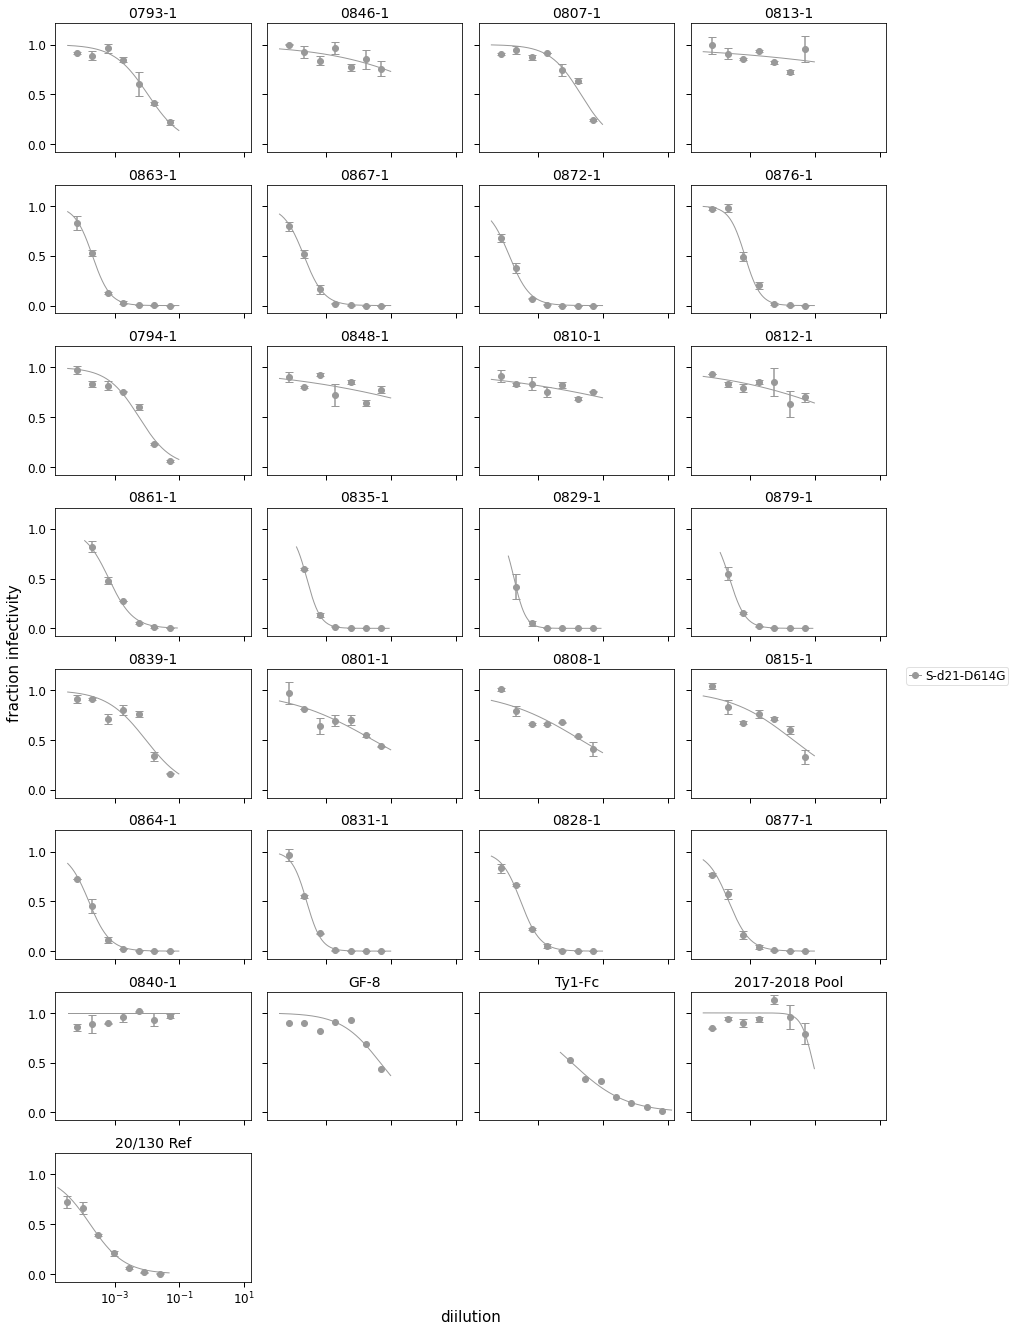

In [46]:
fig, axes = fits_rnd1.plotSera(xlabel='diilution')

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.


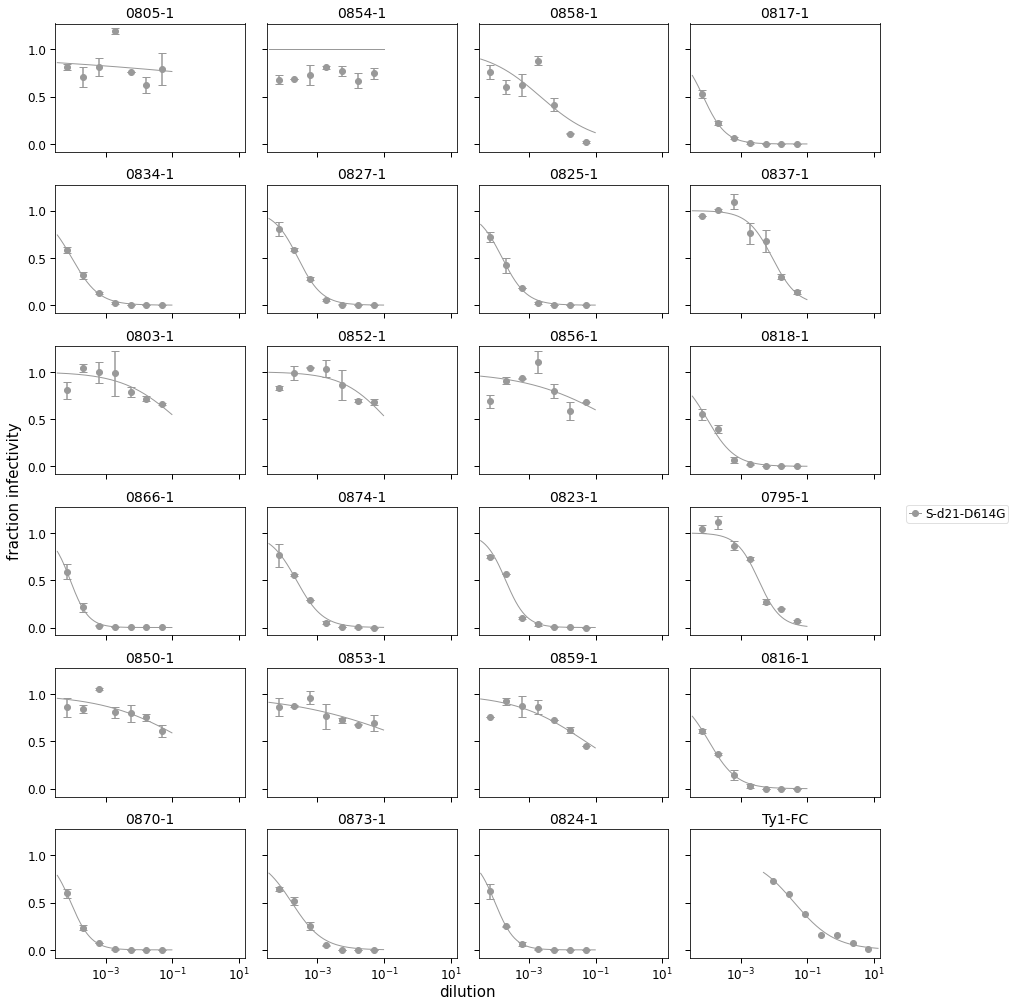

In [47]:
fig, axes = fits_rnd2_nosp.plotSera(xlabel='dilution')

The IC50 is 0.0108


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.


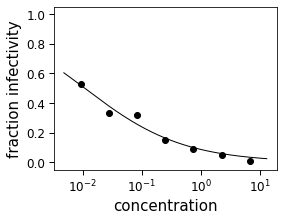

In [20]:
curve = fits_rnd1.getCurve(serum='Ty1-Fc', virus='S-d21-D614G', replicate='1')
print(f"The IC50 is {curve.ic50():.3g}")
fig, ax = curve.plot()

The IC50 is 0.0405


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.


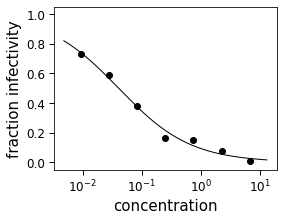

In [21]:
curve = fits_rnd2.getCurve(serum='Ty1-FC', virus='S-d21-D614G', replicate='1')
print(f"The IC50 is {curve.ic50():.3g}")
fig, ax = curve.plot()

### Output csv with relevant data

Output columns: `serum`, `ic50`, `ic90`, `nt50`, `nt90`, `DateSetUp`, `Plate`, `SampleNum`

In [49]:
all_data_df = pd.concat([df_fits_rnd1, df_fits_rnd2])

export_df = all_data_df[['serum', 'ic50', 'ic90', 'nt50', 'nt90', 'DateSetUp', 'Plate', 'SampleNum']]

display(export_df)

export_df.to_csv('./interim_results.csv')

,serum,ic50,ic90,nt50,nt90,DateSetUp,Plate,SampleNum
0,0793-1,0.010629,0.050000,94.080392,20.000000,201013,Plate1,1
1,0846-1,0.050000,0.050000,20.000000,20.000000,201013,Plate1,2
2,0807-1,0.020702,0.050000,48.303432,20.000000,201013,Plate1,3
3,0813-1,0.050000,0.050000,20.000000,20.000000,201013,Plate1,4
4,0863-1,0.000207,0.000825,4834.077623,1211.892515,201013,Plate2,1
5,0867-1,0.000202,0.000975,4962.327707,1026.166490,201013,Plate2,2
6,0872-1,0.000127,0.000646,7854.642838,1547.425381,201013,Plate2,3
7,0876-1,0.000689,0.002331,1452.371218,428.908704,201013,Plate2,4
8,0794-1,0.005679,0.050000,176.078510,20.000000,201013,Plate3,1
9,0848-1,0.050000,0.050000,20.000000,20.000000,201013,Plate3,2
